In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<img src="images\unstructured-data-tesnorflow-workflow.png" />

# 🐶 Using Transfer Learning and TensorFlow 2.0 to Classify Different Dog Breeds

Who's that doggy in the window?

Dogs are incredible. But have you ever been sitting at a cafe, seen a dog and not known what breed it is? I have. And then someone says, "it's an English Terrier" and you think, how did they know that?

In this project we're going to be using machine learning to help us identify different breeds of dogs.

To do this, we'll be using data from the [Kaggle dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/overview). It consists of a collection of 10,000+ labelled images of 120 different dog breeds.

This kind of problem is called multi-class image classification. It's multi-class because we're trying to classify mutliple different breeds of dog. If we were only trying to classify dogs versus cats, it would be called binary classification (one thing versus another).

Multi-class image classification is an important problem because it's the same kind of technology Tesla uses in their self-driving cars or Airbnb uses in atuomatically adding information to their listings.

Since the most important step in a deep learng problem is getting the data ready (turning it into numbers), that's what we're going to start with.

We're going to go through the following TensorFlow/Deep Learning workflow:
1. Get data ready (download from Kaggle, store, import).
2. Prepare the data (preprocessing, the 3 sets, X & y).
3. Choose and fit/train a model ([TensorFlow Hub](https://www.tensorflow.org/hub), `tf.keras.applications`, [TensorBoard](https://www.tensorflow.org/tensorboard), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)).
4. Evaluating a model (making predictions, comparing them with the ground truth labels).
5. Improve the model through experimentation (start with 1000 images, make sure it works, increase the number of images).
6. Save, sharing and reloading your model (once you're happy with the results).

For preprocessing our data, we're going to use TensorFlow 2.x. The whole premise here is to get our data into Tensors (arrays of numbers which can be run on GPUs) and then allow a machine learning model to find patterns between them.

For our machine learning model, we're going to be using a pretrained deep learning model from TensorFlow Hub. 

The process of using a pretrained model and adapting it to your own problem is called **transfer learning**. We do this because rather than train our own model from scratch (could be timely and expensive), we leverage the patterns of another model which has been trained to classify images.


**Turning our images to tensors(numerical)**

In [3]:
# Checkout the labels for our data
labels = pd.read_csv("data/dog-breed-identification/labels.csv")

In [4]:
labels

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


<AxesSubplot:>

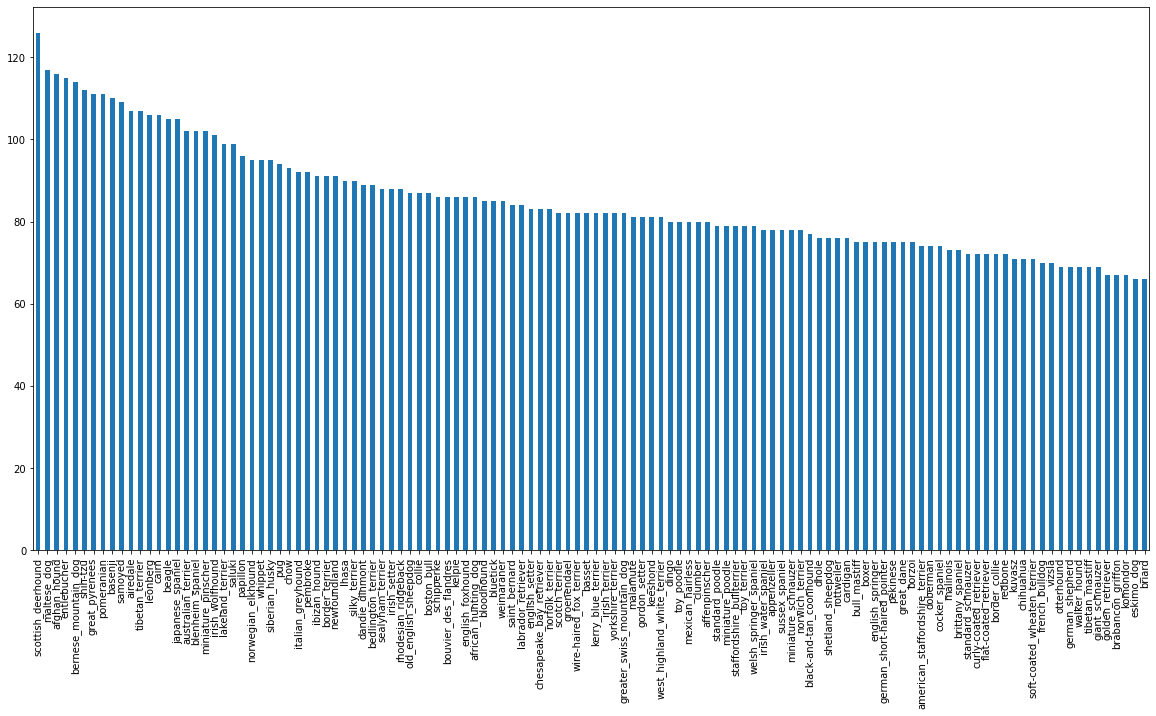

In [5]:
# How many images are there of each breed?

labels["breed"].value_counts().plot.bar(figsize=(20,10))

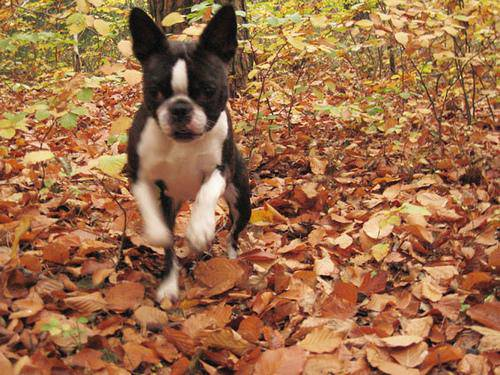

In [6]:
from IPython.display import Image
Image("data/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

In [7]:
# create pathname from labels id
filenames = ["data/dog-breed-identification/train/"+fname+".jpg" for fname in labels['id']]

filenames[:10]

['data/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [8]:
# check the number of the filename matches with the train dataset
import os

if len(os.listdir("data/dog-breed-identification/train/")) == len(filenames):
    print("Numbers are equal Please proceed!! :)")
else:
    print("Number are not equal Please check!!")

Numbers are equal Please proceed!! :)


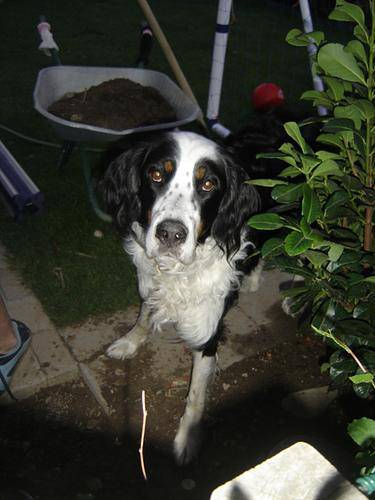

In [9]:
# let's check filenames list by using Image library
Image(filenames[2000])

**Convert the labels to the numbers**


In [10]:
labels_b = labels["breed"]
labels_b = np.array(labels_b)
labels_b
# or we can also do this way
# labels_b = labels["breed"].to_numpy()

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [11]:
len(labels)

10222

**length of filenames matches the number of labels**


In [12]:
if len(filenames) == len(labels_b):
    print("They are matched : )")
else:
    print("They are not matched :(")

They are matched : )


In [13]:
# find the unique labels
unique_breeds = np.unique(labels_b)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [14]:
# converting a single unique breed to boolean
labels_b[0] == unique_breeds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [15]:
boolean_labels = [label == unique_breeds for label in labels_b]
len(boolean_labels)  # for every unique breed we have got arrays of boolean values

10222

In [16]:
# Example : Turning boolean values into the integers
print(labels_b[0])
print(np.where(unique_breeds == labels_b[0]))
print(boolean_labels[0].argmax()) # returns index of the max element
print(boolean_labels[0].astype(int))

boston_bull
(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


# Create a Validation Set and split the data

In [17]:
# create x and y labels
x = filenames
y = boolean_labels

In [18]:
NUM_IMAGES = 1000

In [19]:
from sklearn.model_selection import train_test_split

x_train , x_valid , y_train , y_valid = train_test_split(x,y,test_size=0.2)

len(x_train) , len(x_valid) , len(y_train) , len(y_valid)

(8177, 2045, 8177, 2045)

In [20]:
x_train[:2]

['data/dog-breed-identification/train/f8346f0bac3aae2f49113b3d7dabb812.jpg',
 'data/dog-breed-identification/train/f9bf654be6ec7d1c40935aa397a3edbf.jpg']

In [21]:
x_valid[:2]

['data/dog-breed-identification/train/08946697b3e50e602d6bea765c8fb9f5.jpg',
 'data/dog-breed-identification/train/0512c1a59449a9c8c83c95722028ac90.jpg']

In [22]:
y_train[:2]

[array([False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False,  True, False, False, Fal

# PreProcessing Images (turning images into Tensorsm)

In [23]:
# convert image into an numpy array
from matplotlib.pyplot import imread
image = imread(filenames[69])

In [24]:
image , image.shape

(array([[[  4,   3,   0],
         [  7,   6,   2],
         [  9,   8,   4],
         ...,
         [  6,   6,   6],
         [  6,   6,   6],
         [  6,   6,   6]],
 
        [[  4,   3,   0],
         [  3,   2,   0],
         [  1,   0,   0],
         ...,
         [  5,   5,   5],
         [  5,   5,   5],
         [  5,   5,   5]],
 
        [[  7,   6,   2],
         [  3,   2,   0],
         [  1,   0,   0],
         ...,
         [  4,   4,   4],
         [  4,   4,   4],
         [  4,   4,   4]],
 
        ...,
 
        [[118, 118, 116],
         [117, 117, 115],
         [116, 116, 114],
         ...,
         [ 16,  15,  11],
         [ 14,  13,   9],
         [ 12,  11,   7]],
 
        [[111, 111, 109],
         [111, 111, 109],
         [112, 112, 110],
         ...,
         [ 15,  14,  10],
         [ 14,  13,   9],
         [ 13,  12,   8]],
 
        [[107, 107, 105],
         [108, 108, 106],
         [110, 110, 108],
         ...,
         [ 14,  13,   9],
  

In [25]:
# converting into Tensors
tf.constant(image)

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[  4,   3,   0],
        [  7,   6,   2],
        [  9,   8,   4],
        ...,
        [  6,   6,   6],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[  4,   3,   0],
        [  3,   2,   0],
        [  1,   0,   0],
        ...,
        [  5,   5,   5],
        [  5,   5,   5],
        [  5,   5,   5]],

       [[  7,   6,   2],
        [  3,   2,   0],
        [  1,   0,   0],
        ...,
        [  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4]],

       ...,

       [[118, 118, 116],
        [117, 117, 115],
        [116, 116, 114],
        ...,
        [ 16,  15,  11],
        [ 14,  13,   9],
        [ 12,  11,   7]],

       [[111, 111, 109],
        [111, 111, 109],
        [112, 112, 110],
        ...,
        [ 15,  14,  10],
        [ 14,  13,   9],
        [ 13,  12,   8]],

       [[107, 107, 105],
        [108, 108, 106],
        [110, 110, 108],
        ...,
        [ 14,  13,   

# To preprocess our images into Tensors we need to do certain things by using the functions

1. Take an image filepath as an input
2. Use Tensorflow to read the file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel from 0-255 to 0-1)
5. Resize the `image` to be a shape of (224,224)
6. Return the modified `image`

In [26]:
# define image size
IMG_SIZE = 224

def preprocess_image(img_path, img_size=IMG_SIZE):
    """
    Take an image file as an input and convert into the Tensors.
    """
    
    # Read in an image file
    image = tf.io.read_file(img_path)
    
    # Turn the jpeg image into numerical Tensor with 3 color channel (RGB)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # convert the color channels from 0-255 to 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Resize the image to the desired values
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
    
    return image
    

In [27]:
sample = tf.io.read_file(filenames[69])
sample

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [28]:
sample = tf.image.decode_jpeg(sample , channels=3)
sample

<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[  3,   4,   0],
        [  6,   7,   2],
        [  7,   8,   3],
        ...,
        [  5,   5,   5],
        [  5,   5,   5],
        [  5,   5,   5]],

       [[  2,   3,   0],
        [  1,   2,   0],
        [  0,   1,   0],
        ...,
        [  4,   4,   4],
        [  4,   4,   4],
        [  4,   4,   4]],

       [[  6,   7,   1],
        [  1,   2,   0],
        [  0,   1,   0],
        ...,
        [  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3]],

       ...,

       [[118, 119, 114],
        [117, 118, 113],
        [115, 116, 111],
        ...,
        [ 16,  15,  10],
        [ 13,  12,   7],
        [ 11,  10,   5]],

       [[111, 112, 107],
        [111, 112, 107],
        [111, 112, 107],
        ...,
        [ 15,  14,   9],
        [ 14,  13,   8],
        [ 13,  12,   7]],

       [[106, 107, 102],
        [107, 108, 103],
        [110, 111, 106],
        ...,
        [ 13,  12,   

In [29]:
sample = tf.image.convert_image_dtype(sample, tf.float32)
sample

<tf.Tensor: shape=(375, 500, 3), dtype=float32, numpy=
array([[[0.01176471, 0.01568628, 0.        ],
        [0.02352941, 0.02745098, 0.00784314],
        [0.02745098, 0.03137255, 0.01176471],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       [[0.00784314, 0.01176471, 0.        ],
        [0.00392157, 0.00784314, 0.        ],
        [0.        , 0.00392157, 0.        ],
        ...,
        [0.01568628, 0.01568628, 0.01568628],
        [0.01568628, 0.01568628, 0.01568628],
        [0.01568628, 0.01568628, 0.01568628]],

       [[0.02352941, 0.02745098, 0.00392157],
        [0.00392157, 0.00784314, 0.        ],
        [0.        , 0.00392157, 0.        ],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471]],

       ...,

       [[0.46274513, 0.4666667 , 0.44705886],
        [0.45

In [30]:
sample = tf.image.resize(sample , size=(224,224))
sample

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[1.44335870e-02, 1.83551554e-02, 3.20331287e-03],
        [1.37881711e-02, 1.77097414e-02, 3.38901114e-03],
        [2.08912752e-04, 4.13048174e-03, 0.00000000e+00],
        ...,
        [1.17647070e-02, 1.17647070e-02, 1.17647070e-02],
        [1.82860643e-02, 1.82860643e-02, 1.82860643e-02],
        [1.82860643e-02, 1.82860643e-02, 1.82860643e-02]],

       [[1.20994570e-02, 1.60210263e-02, 2.04762258e-03],
        [7.37413415e-04, 4.65898216e-03, 5.18573157e-04],
        [1.90108865e-02, 2.29324568e-02, 6.49486494e-04],
        ...,
        [1.21200671e-02, 1.21200671e-02, 1.21200671e-02],
        [1.17209386e-02, 1.17209386e-02, 1.17209386e-02],
        [1.17209386e-02, 1.17209386e-02, 1.17209386e-02]],

       [[1.10203698e-01, 1.08750619e-01, 8.79085362e-02],
        [1.20225839e-01, 1.18772753e-01, 9.79306623e-02],
        [1.13384195e-01, 1.11931115e-01, 9.10890251e-02],
        ...,
        [1.59022100e-02, 1.59022

# Turning our data into the batches of 32

Batches means set of 32 will train at a time and next 32 like wise entire dataset is trained
We mainly use batches system because if we train 10k + images at a tim ethere will be the shortage of the memory of our GPU
So it is very good to train them into the batches 

In order to use Tensorflow effiectively we should use the labels as tuple `(image, label)`

In [31]:
# Create a simple function

def get_image_label(img_path, labels):
    """
    Takes an image path as an input and return as of them tuple of image and label
    """
    
    image = preprocess_image(img_path)
    
    return image, labels

In [32]:
preprocess_image(x[42], tf.constant(y[42]))

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.3264178 , 0.5222886 , 0.3232816 ],
        [0.2537167 , 0.44366494, 0.24117757],
        [0.25699762, 0.4467087 , 0.23893751],
        ...,
        [0.29325107, 0.5189916 , 0.3215547 ],
        [0.29721776, 0.52466875, 0.33030328],
        [0.2948505 , 0.5223015 , 0.33406618]],

       [[0.25903144, 0.4537807 , 0.27294815],
        [0.24375686, 0.4407019 , 0.2554778 ],
        [0.2838985 , 0.47213382, 0.28298813],
        ...,
        [0.2785345 , 0.5027992 , 0.31004712],
        [0.28428748, 0.5108719 , 0.32523635],
        [0.28821915, 0.5148036 , 0.32916805]],

       [[0.20941195, 0.40692952, 0.25792548],
        [0.24045378, 0.43900946, 0.2868911 ],
        [0.29001117, 0.47937486, 0.32247734],
        ...,
        [0.26074055, 0.48414773, 0.30125174],
        [0.27101526, 0.49454468, 0.32096273],
        [0.27939945, 0.5029289 , 0.32934693]],

       ...,

       [[0.00634795, 0.03442048, 0.0258106 ],
        [0.01

# Convert into the batches

In [33]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to convert the data into the batches
def create_batches(x, y=None, batch_size=BATCH_SIZE,val_data=False, test_data=False):
    """
    Create batches of data of our images (X) and (Y)
    Shuffle the data if it's training data but doesn't shuffle it it's validation data
    Also accepts test data as an input( no labels)
    """
    
    if test_data:
        print("Creating the test Data Batches......")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))  # only filepaths no labels
        data_batch = data.map(preprocess_image).batch(BATCH_SIZE)
    elif val_data:
        print("Creating the valid Data Batches.....")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    else:
        print("Creating the Training Data Batches....")

        # Turn filepaths and labels into the Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x),tf.constant(y)))

        # Shuffling pathnames and labels before mapping image preprocessor funcion is faster than shuffling images
        data = data.shuffle(buffer_size=len(x))

        # Creata a image, label this will also convert the data preprocessed image
        data = data.map(get_image_label)

        # Turning into the data batches
        data_batch = data.batch(BATCH_SIZE)
    
    return data_batch

In [34]:
# Create the training and validation data batches
train_data = create_batches(x_train, y_train)
valid_data = create_batches(x_valid, y_valid, val_data=True)

Creating the Training Data Batches....
Creating the valid Data Batches.....


In [35]:
train_data.element_spec , valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [36]:
#create a function for viewing the images for the data batches
def show_25_images(image, labels):
    """
    Display a plot of 25 images and their labels from a data batch
    """
    # Setup the figure
    plt.figure(figsize=(10,10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create a subplots ( 5 rows and 5 columns )
        ax = plt.subplot(5 , 5 , i+1)
        # Display an image
        plt.imshow(image[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        

In [37]:
unique_breeds[y[0].argmax()]

'boston_bull'

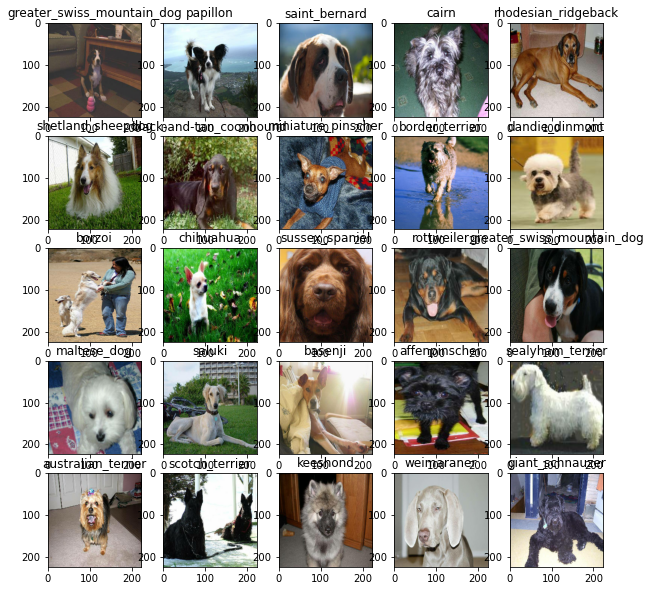

In [38]:
train_images, train_labels = next(train_data.as_numpy_iterator())
# Now let's visualize the data by using the function
show_25_images(train_images, train_labels)

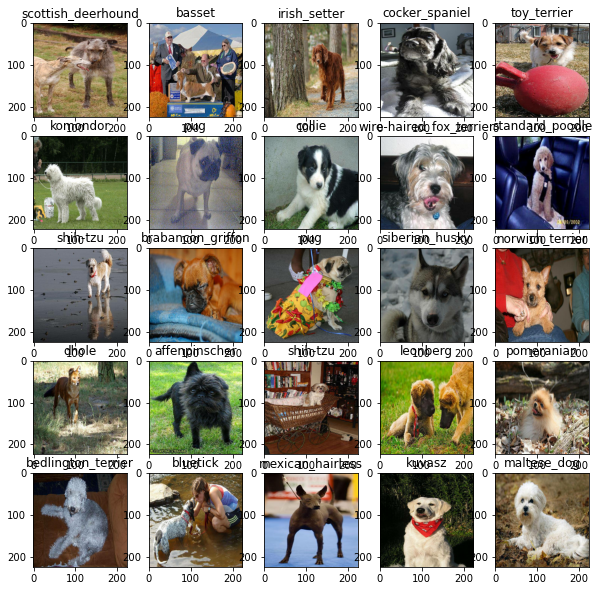

In [39]:
# now let's visualize the validation data
val_images , val_labels = next(valid_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

# Building a model
* Before we build a model, there are few things we need to define:
    * The input shape(our images shape , in the form of Tensors) to our model
    * The output shape(image labels, in the form of Tensors) of our model
    * The URL of the model we want to use from Tensorflow hub: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [40]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] #batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup Model Hub from TensorHub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

# create a function which
* Takes input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras Model in sequential fashion( do this first , and then that)
* Compiles the model ( says how it should be evaluated and improved)
* Builds the model (tells the model the input shape it'll be getting )
* Returns the model

In [41]:
def create_model(input_shape=INPUT_SHAPE,output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
    print(f"Building model by using {model_url}")
    
    # Setup the model layers or we can say instantiate the model
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url), # Layer 1 (input layers)
        tf.keras.layers.Dense(units=output_shape,
                             activation="softmax") # Layer 2 (output layers)
    ])
    
    # Compile the model
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])
#     model.compile(
#     loss=tf.keras.losses.CategoricalCrossentropy(),
#     optimizers=tf.keras.optimizers.Adam(),
#     metrics=["accuracy"]
#     )
    
    # Build the model
    model.build(input_shape)
    
    return model

In [42]:
#  !pip install --upgrade tensorflow_hub

In [43]:
model = create_model()
model.summary()

Building model by using https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              5432713   
_________________________________________________________________
dense (Dense)                (None, 120)               120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


# callback functions


callback functions are helper functions that can be used when the model is training. It is used for the functions as the model should stops training when the it the model is not improving more and many more functions can be use by using **calback** functions



Callbacks can be passed to keras methods such as fit, evaluate, and predict in order to hook into the various stages of the model training and inference lifecycle.

>https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback


**Two callback**

we'll be creating two callbacks 
* **TensorBoard** : helps track our model progress
* another : for early stopping if our model takes too long to trained.

**TensorBoard Callback**

Now it's time to use our 🪄🧝🏻 function to use the tensorboard callback


To setup a **tensorboard** extension we need to do following things:
1. Load the tensorboard notebook extension 
2. Create a Tensorboard call back which is able to save logs to a directory and pass it to our models `fit()` function
3. Visualize our models training logs with the `%tensorboard` magic 🧝🏻🪄 function (we use this after the model training :))

**1. Load the tensorboard notebook extension** ✅

In [44]:
# Load tensorboard extension
%load_ext tensorboard

**2. Create a Tensorboard call back which is able to save logs to a directory and pass it to our models `fit()` function** ✅

In [45]:
import datetime

# create a function to build a Tensorflow board
def create_tensorboard_callback():
    # Create a log directory for storing Tensorboard logs
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
    
    return tf.keras.callbacks.TensorBoard(logdir)

In [46]:
# Creating an early stop callback

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                 patience=3)

**Create a function which trains the model**


1. Create a model using `create_model()`
2. Setup a TensorBoard callback using `create_tensor_callback()`
3. Call the `fit()` function on our model passing it the training data , vaidation data, number of epochs to train for ( `NUM_EPOCHS`) and the callbacks we'd like to use.
4. Return the model

In [47]:
NUM_EPOCHS = 100

In [48]:
# Builds a function to train and return the trained model
def train_model():
    """
    Trains a given model and returns as the Trained model.
    """
    
    # Create a model
    model = create_model()
    
    # Create a tensorboard callback
    tensorboard = create_tensorboard_callback()
    
    # Fit the model
    
    model.fit(x=train_data,
             epochs=NUM_EPOCHS,
             validation_data=valid_data,
             validation_freq=1,
             callbacks=[tensorboard, early_stopping])
    
    # Returning the model
    return model
    

In [49]:
# import tensorflow as tf
# config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(allow_growth=True))
# sess = tf.compat.v1.Session(config=config)

In [50]:
# fit the model

model = train_model()

Building model by using https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
256/256 [==============================] - 48s 150ms/step - loss: 1.4775 - accuracy: 0.6427 - val_loss: 0.7631 - val_accuracy: 0.7667
Epoch 2/100
256/256 [==============================] - 35s 138ms/step - loss: 0.4017 - accuracy: 0.8847 - val_loss: 0.7253 - val_accuracy: 0.7692
Epoch 3/100
256/256 [==============================] - 36s 140ms/step - loss: 0.2312 - accuracy: 0.9415 - val_loss: 0.7015 - val_accuracy: 0.7844
Epoch 4/100
256/256 [==============================] - 36s 140ms/step - loss: 0.1430 - accuracy: 0.9697 - val_loss: 0.7220 - val_accuracy: 0.7897
Epoch 5/100
256/256 [==============================] - 36s 139ms/step - loss: 0.0977 - accuracy: 0.9830 - val_loss: 0.7157 - val_accuracy: 0.7917
Epoch 6/100
256/256 [==============================] - 36s 140ms/step - loss: 0.0715 - accuracy: 0.9894 - val_loss: 0.7469 - val_accuracy: 0.7897
Epoch 7/100
256/256 [=======

In [51]:

# checking the tensorboard logs
%tensorboard --logdir logs

# if it fails C:\Users\Chandrashekhar\AppData\Local\Temp\.tensorboard-info clear the contents
# delte the logs

Reusing TensorBoard on port 6006 (pid 14344), started 0:50:37 ago. (Use '!kill 14344' to kill it.)

# Making and evaluating predictions using a trained model


In [52]:
# make prediction on valid data
predictions_valid_data = model.predict(valid_data, verbose=1)
predictions_valid_data

64/64 [==============================] - 7s 102ms/step


array([[1.50458177e-07, 2.49619170e-09, 4.26582233e-07, ...,
        7.38123854e-05, 1.02084652e-08, 8.48279502e-10],
       [2.01681814e-07, 2.58114454e-07, 2.49238769e-06, ...,
        1.67402774e-01, 3.81510472e-06, 2.42328809e-07],
       [2.89176155e-10, 1.67280483e-08, 4.84996002e-11, ...,
        4.91519769e-10, 1.63353844e-10, 3.91414545e-09],
       ...,
       [2.92434474e-04, 3.86754205e-11, 4.20076105e-07, ...,
        8.92006938e-06, 9.39593804e-07, 2.77477056e-07],
       [1.23451055e-05, 4.55673792e-08, 3.21723714e-09, ...,
        5.61214859e-11, 1.78962412e-09, 1.34792772e-08],
       [1.20464594e-09, 3.54186724e-09, 8.08923040e-10, ...,
        9.63734692e-09, 1.74277787e-10, 1.70151712e-10]], dtype=float32)

In [53]:
predictions_valid_data[0]

array([1.50458177e-07, 2.49619170e-09, 4.26582233e-07, 9.25956742e-11,
       5.27292709e-10, 1.58356563e-08, 2.71614481e-10, 4.23002022e-10,
       1.90112058e-11, 1.08959203e-10, 1.94546779e-09, 1.99045338e-12,
       5.81077764e-12, 3.43068796e-10, 1.27265518e-10, 1.21811929e-08,
       3.28831966e-08, 3.11999884e-07, 6.91193691e-06, 9.23256422e-08,
       3.23131360e-07, 3.57070906e-09, 1.33289524e-09, 1.71147785e-09,
       1.30971323e-08, 1.53156265e-09, 4.76799323e-06, 5.06630349e-10,
       9.56682342e-08, 1.72385195e-09, 2.80492601e-10, 2.93370661e-10,
       1.03084194e-10, 2.59590234e-08, 1.38861207e-08, 1.46126486e-10,
       1.10267617e-09, 4.47578363e-10, 7.88203502e-10, 1.20089527e-09,
       3.34344925e-08, 3.08930703e-09, 9.03420221e-12, 8.85442830e-09,
       1.18146548e-09, 8.28825120e-10, 1.28473088e-09, 4.32592024e-08,
       2.37962851e-07, 4.34628982e-12, 2.10293741e-10, 5.04268428e-06,
       6.98107527e-09, 4.31397051e-09, 1.11359443e-10, 1.50348725e-07,
      

In [54]:
np.sum(predictions_valid_data[0]) , np.sum(predictions_valid_data[1]) , np.sum(predictions_valid_data[2]) , np.sum(predictions_valid_data[3])

(1.0000001, 1.0, 1.0, 1.0000001)

In [55]:
predictions_valid_data.shape

(2045, 120)

In [56]:
len(x_valid)

2045

In [57]:
len(unique_breeds)

120

In [58]:
# First Predictions
index = 200

print(predictions_valid_data[index])
print(f"MAx value in the predictions is {np.max(predictions_valid_data[index])}")
print(f"Sum of the values is {np.sum(predictions_valid_data[index])}")
print(f"Max value index is {np.argmax(predictions_valid_data[index])}")
print(f"Max value label is {unique_breeds[np.argmax(predictions_valid_data[index])]}")

[2.8219885e-10 1.6132928e-07 2.6414648e-09 1.8781204e-08 4.3041723e-08
 5.7703670e-10 1.1511033e-10 1.5694759e-09 3.7994887e-09 8.2543722e-10
 1.8946413e-09 1.7147569e-09 1.0164678e-09 1.7033835e-09 3.0942698e-05
 1.4006128e-08 1.6651527e-10 9.4249117e-08 7.9655438e-10 2.2019229e-08
 2.2273974e-07 1.0823284e-02 4.4662315e-07 1.3160420e-07 4.2875731e-11
 9.8903406e-01 6.3538352e-10 3.7169270e-10 5.0923044e-09 6.9077230e-11
 6.0548501e-07 1.3440959e-06 5.5697047e-08 5.3656629e-10 1.0920364e-09
 2.2842025e-08 3.1278893e-10 3.8462275e-07 1.1234653e-09 2.1460389e-08
 1.1214181e-10 9.9645392e-10 4.0097986e-10 4.4909670e-10 1.8809964e-11
 1.9988847e-06 1.6929727e-10 8.7324181e-10 6.4230244e-07 8.8340766e-09
 1.8500039e-09 3.8463961e-05 2.6051605e-08 2.3974553e-09 2.5783303e-10
 4.7251238e-09 6.2503280e-11 5.9815434e-08 2.2003852e-09 1.3436096e-07
 1.3611515e-10 7.6870489e-12 2.0387931e-08 6.1790206e-10 3.4653481e-11
 3.6380060e-10 1.4210182e-11 1.9824046e-08 2.0750026e-09 1.3681795e-06
 3.865

In [59]:
# Turning the predcitions probablities into there respective labels

def get_pred_labels(predictions_probabilities):
    """
    Truns the predicition probabilities into there respective labels
    """
    
    return unique_breeds[np.argmax(predictions_probabilities)]


# Get a prediction label based on the specific index
pred_label = get_pred_labels(predictions_valid_data[69])
pred_label

'beagle'

In [60]:
# create a function to unbatch the data
def unbatchify(batch_data):
    """
    Takes an input of the batch data and return into the unbatched data.
    Note it will return as (images, labels)
    """
    # let's now unbatch the data
    images_ = []
    labels_ = []

    for image, label in batch_data.unbatch().as_numpy_iterator():
        # append into the list
        images_.append(image)
        labels_.append(unique_breeds[np.argmax(label)])
    
    return images_, labels_

# now let's unbatchify the batch data
val_images , val_labels = unbatchify(valid_data)

val_labels[0]

'scottish_deerhound'

In [61]:
# # let's now unbatch the data
# images_ = []
# labels_ = []

# for image, label in valid_data.unbatch().as_numpy_iterator():
#     # append into the list
#     images_.append(image)
#     labels_.append(label)
    
    
# images_[0] , labels_[0]

Let's make some function to make these all a bit more visaulize.

We'll create a function which:

* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prediction probabilities to a predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [62]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_labels(pred_prob)
    
    
  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

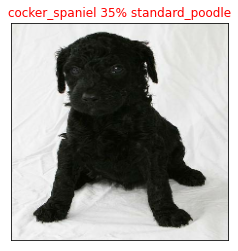

In [63]:
plot_pred(prediction_probabilities=predictions_valid_data,
          labels=val_labels,
          images=val_images,
          n=99)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:

* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using `get_pred_label()` ✅
* Find the top 10:
   * Prediction probabilities indexes ✅
   * Prediction probabilities values ✅
   * Prediction labels ✅
   
   
   
Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [64]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_labels(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
#   print(np.argmax(top_10_pred_labels == true_label))
#   print(top_plot[1])
#   print(top_plot[0])
#   print(top_plot[2])
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
    #top-plot basically have each bar indexes so argmax return indices of that bar which is true.
  else:
    pass

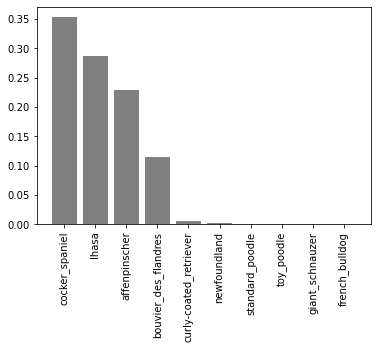

In [65]:
plot_pred_conf(prediction_probabilities=predictions_valid_data,
                labels=val_labels,
                n=99)

In [66]:
# pred.argsort()[-10:][::-1]

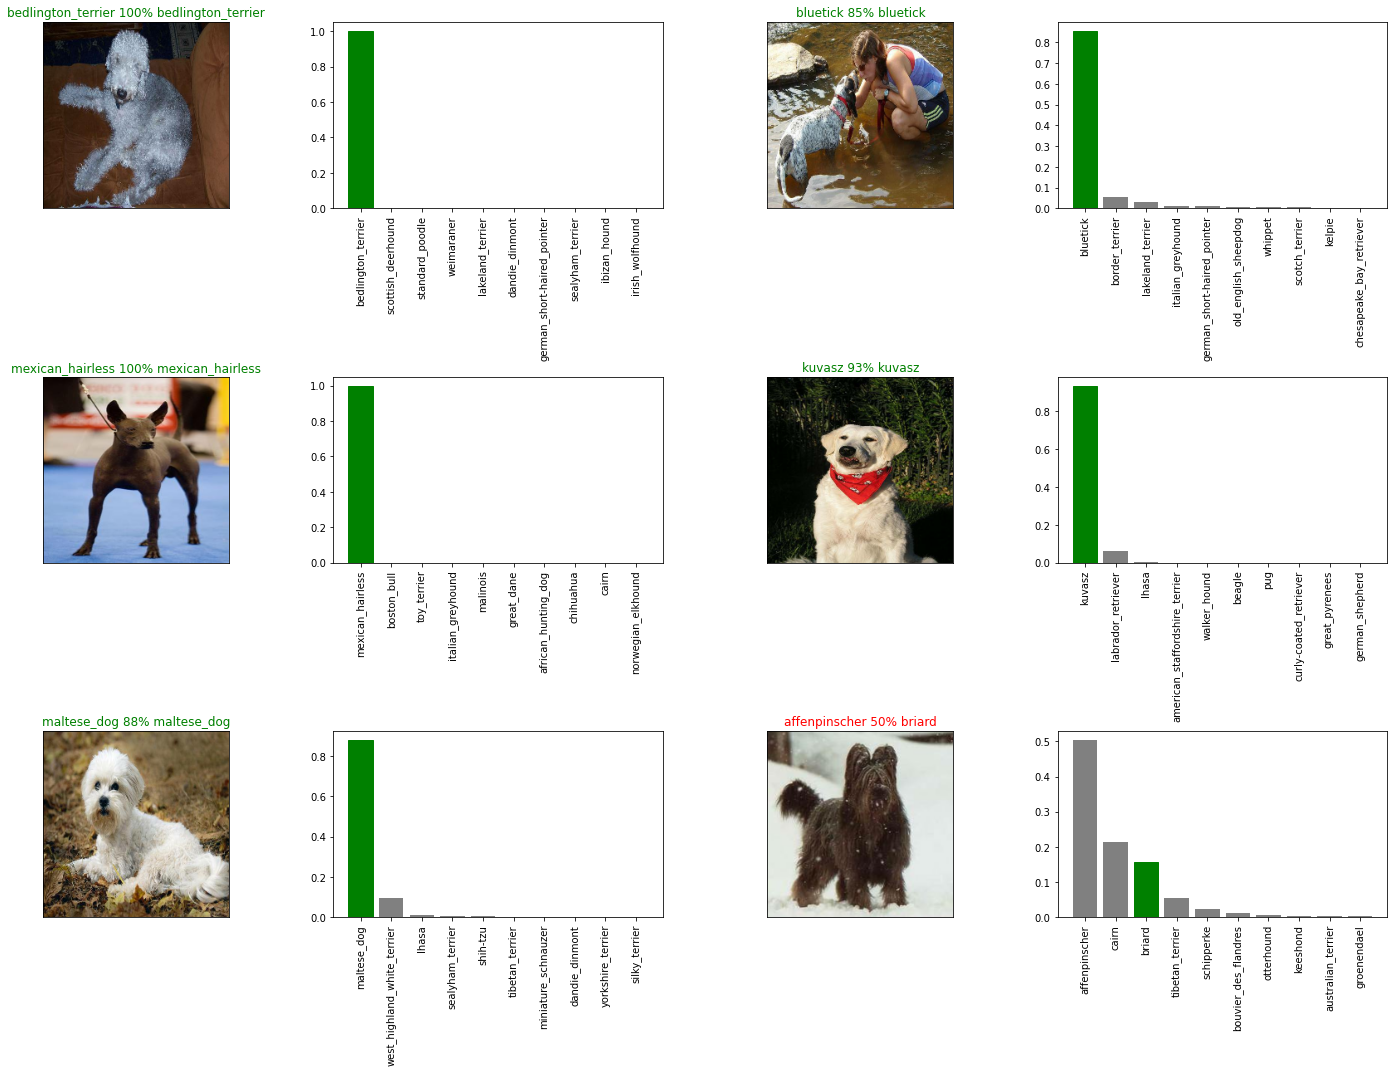

In [67]:
# Let's check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions_valid_data,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions_valid_data,
                 labels=val_labels,
                 n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

# Saving and reloading the model

In [68]:
# create a function to save the model
def save_model(model, suffix=None):
    """
    Save the model into the respective directory
    """
    model_dir = os.path.join("models",datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
    
    model_path = model_dir + "-" + suffix + ".h5" 
    
    print(f"Saving the model to the {model_path}.....")
    model.save(model_path)
    
    return model_path

In [69]:
# create a function to reload the model
def reload_model(model_path):
    """
    Reload the save model from the specific directory.
    """
    
    print(f"Reloading the save model from {model_path}...")
    model = tf.keras.models.load_model(model_path,
                                      custom_objects={"KerasLayer": hub.KerasLayer})
    
    return model

In [70]:
# Now let's save and reload the model by using the functions we have created
# save the model
save_model(model, suffix="mobilenet-v2-Adam_Full-Dataset")

Saving the model to the models\2022-06-24-14-45-01-mobilenet-v2-Adam_Full-Dataset.h5.....


'models\\2022-06-24-14-45-01-mobilenet-v2-Adam_Full-Dataset.h5'

In [71]:
# reload the model
loaded_model = reload_model("models/2022-06-24-14-01-05-mobilenet-v2-Adam_Full-Dataset.h5")

Reloading the save model from models/2022-06-24-14-01-05-mobilenet-v2-Adam_Full-Dataset.h5...


In [72]:
model.evaluate(valid_data)

64/64 [==============================] - 7s 109ms/step - loss: 0.8641 - accuracy: 0.7892


[0.8640924096107483, 0.7892420291900635]

In [73]:
loaded_model.evaluate(valid_data)

64/64 [==============================] - 8s 110ms/step - loss: 0.1587 - accuracy: 0.9594


[0.15865714848041534, 0.9594132304191589]

# Making predictions on the test dataset
Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Luckily we created `create_data_batches()` earlier which can take a list of filenames as input and conver them into Tensor batches.

To make predictions on the test data, we'll:

* Get the test image filenames. ✅
* Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to True (since the test data doesn't have labels). ✅
* Make a predictions array by passing the test batches to the `predict()` method called on our model.

In [74]:
# Load the test image file name
test_path = "data/dog-breed-identification/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

In [75]:
test_filenames[:10]

['data/dog-breed-identification/test/000621fb3cbb32d8935728e48679680e.jpg',
 'data/dog-breed-identification/test/00102ee9d8eb90812350685311fe5890.jpg',
 'data/dog-breed-identification/test/0012a730dfa437f5f3613fb75efcd4ce.jpg',
 'data/dog-breed-identification/test/001510bc8570bbeee98c8d80c8a95ec1.jpg',
 'data/dog-breed-identification/test/001a5f3114548acdefa3d4da05474c2e.jpg',
 'data/dog-breed-identification/test/00225dcd3e4d2410dd53239f95c0352f.jpg',
 'data/dog-breed-identification/test/002c2a3117c2193b4d26400ce431eebd.jpg',
 'data/dog-breed-identification/test/002c58d413a521ae8d1a5daeb35fc803.jpg',
 'data/dog-breed-identification/test/002f80396f1e3db687c5932d7978b196.jpg',
 'data/dog-breed-identification/test/0036c6bcec6031be9e62a257b1c3c442.jpg']

In [76]:
# create a test data batches of 32 
test_data = create_batches(test_filenames, test_data=True)

Creating the test Data Batches......


In [77]:
# Make predictions on test data by using trained model
test_predicitons = model.predict(test_data, verbose=1)

324/324 [==============================] - 34s 105ms/step


In [81]:
# we can also save the model by using the numpy 
np.savetxt("data/dog-breed-identification/preds_array.csv",test_predicitons,delimiter=",")

In [82]:
test_predicitons = np.loadtxt("data/dog-breed-identification/preds_array.csv", delimiter=",")

# Preparing test dataset predictions for Kaggle
Looking at the Kaggle sample submission, we find that it wants our models prediction probaiblity outputs in a DataFrame with an ID and a column for each different dog breed. https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:

* Create a pandas DataFrame with an ID column as well as a column for each dog breed. ✅
* Add data to the ID column by extracting the test image ID's from their filepaths.
* Add data (the prediction probabilites) to each of the dog breed columns.
* Export the DataFrame as a CSV to submit it to Kaggle.

In [84]:
# create a pandas dataframe with empty data
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))

In [85]:
preds_df

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [86]:
# append test image id into the data frame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df['id'] = test_ids

In [87]:
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00102ee9d8eb90812350685311fe5890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0012a730dfa437f5f3613fb75efcd4ce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001510bc8570bbeee98c8d80c8a95ec1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001a5f3114548acdefa3d4da05474c2e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
preds_df[list(unique_breeds)] = test_predicitons
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,2.333735e-10,1.366641e-09,1.201561e-12,1.924186e-11,1.539312e-11,3.118020e-10,2.080956e-13,6.401117e-10,1.529546e-11,...,8.951220e-11,2.233159e-11,2.493488e-12,1.470178e-12,1.788159e-11,8.619230e-11,9.286073e-11,1.085347e-11,7.006429e-09,1.197507e-09
1,00102ee9d8eb90812350685311fe5890,6.510960e-06,1.240819e-06,1.257525e-06,1.867365e-08,2.264945e-05,9.831982e-07,8.035079e-06,1.778129e-06,5.557415e-08,...,7.956697e-08,2.071324e-06,6.714924e-08,1.628850e-06,4.020460e-07,8.134218e-07,3.756561e-04,1.790996e-09,1.239876e-07,9.480145e-09
2,0012a730dfa437f5f3613fb75efcd4ce,8.373697e-10,1.028058e-05,1.601118e-07,1.306770e-08,2.513015e-08,4.746095e-07,5.352281e-10,3.652773e-10,4.148797e-08,...,3.308409e-12,3.558193e-10,2.003525e-06,1.222526e-05,1.512669e-06,3.850136e-06,3.555674e-11,2.283161e-06,1.530109e-09,1.248751e-09
3,001510bc8570bbeee98c8d80c8a95ec1,3.354321e-07,6.621988e-07,5.768395e-06,3.752674e-08,2.711315e-04,3.345633e-08,2.674687e-12,2.007259e-09,6.776374e-07,...,5.526371e-05,4.294133e-08,2.081964e-08,4.886549e-11,8.431629e-07,2.540058e-08,1.007381e-12,1.051322e-04,1.804822e-09,3.029631e-07
4,001a5f3114548acdefa3d4da05474c2e,8.792878e-05,3.955558e-05,2.831101e-08,3.851826e-09,1.589731e-08,2.955195e-10,2.564093e-09,1.875910e-08,7.133131e-08,...,1.790319e-06,2.148453e-09,7.127350e-10,5.676461e-10,6.148979e-10,2.068430e-09,3.614750e-10,1.267982e-07,5.019265e-09,1.350399e-06


In [91]:
preds_df.to_csv("data/dog-breed-identification/full_model_predictions_mobilenetv2_Adam.csv",index=False)

# custom images

In [102]:
# Get custom image filepaths
custom_path = "data/dog-breed-identification/custom/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths

['data/dog-breed-identification/custom/1-face.jpg',
 'data/dog-breed-identification/custom/afador-mixed-dog-breed-pictures-1-650x599.jpg',
 'data/dog-breed-identification/custom/akita-pit-mixed-dog-breed-pictures-1-650x432.jpg']

In [103]:
# Turn custom images into batch datasets 
custom_data = create_batches(custom_image_paths, test_data=True)
custom_data


Creating the test Data Batches......


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [105]:
# Make predictions on the custom data
custom_preds = model.predict(custom_data)


In [106]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_labels(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels


['great_pyrenees', 'labrador_retriever', 'malinois']

In [107]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)


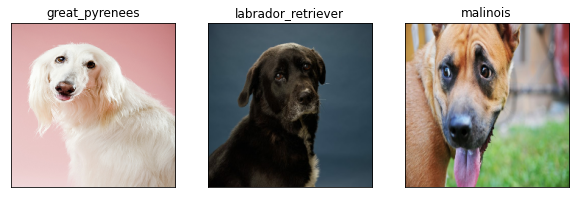

In [108]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)